In [334]:
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
import numpy as np
import random
import seaborn as sns

In [284]:
class strategy_comparison:
    def __init__(self, iterations, limit_1, limit_2, loading_bar = True):
        self.__iterations = iterations
        self.__limits = (limit_1, limit_2)
        self.__loading_bar = loading_bar
        self.__results = self.get_results(iterations, limit_1, limit_2)
        
        
    def get_limits(self):
        return self.__limits
    
    def get_iterations(self):
        return self.__iterations
    
    def get_df(self):
        return self.__results
    
    def get_score(self, hand_ls):
        '''
        gets the best score depending on the given hand
        
        hand_ls[0] -> the array of cards which are not A's or B's
        hand_ls[1] -> the number of A's (Can be 0,1)
        hand_ls[2] -> the number of B's (Can be 0,1)
        '''
        
        # possibilities of outcomes for different combination of A's
        A_possibilities = dict()
        A_possibilities[(0,0)] = [0]
        A_possibilities[(0,1)] = [-11,-1]
        A_possibilities[(1,0)] = [1,10]
        A_possibilities[(1,1)] = [-10,0,10]
        
        # hand_sum is the sum of the hand without considering A's and B's
        hand_sum = sum(hand_ls[0])
        
        # add all possibilities for A's and B's
        current_possibilities = list(map(lambda x: x + hand_sum, A_possibilities[(hand_ls[1], hand_ls[2])]))
        
        # take largest possibility < 26
        for current_possibility in reversed(current_possibilities):
            if current_possibility < 26:
                return current_possibility
        
        # if all possibilities > 26, the hand has "exploded"
        return -1000
    
    def get_draw(self, limit):
        '''draw cards depending on the limit strategy'''
        
        all_cards = np.arange(1,10).tolist() + np.arange(-9,0).tolist()
        all_cards = all_cards + [10]*3 + [-10]*3 + ["A"] + ["B"]
        
        cards_left = all_cards
        current_hand = [list(), 0, 0]
        
        for number_of_cards_left in range (26,0,-1):
            # get random card
            current_index = random.randint(0, number_of_cards_left - 1)
            current_card = cards_left[current_index]
            
            # remove card from cards_left and add to current_hand
            if current_card == "A":
                current_hand[1] += 1
            elif current_card == "B":
                current_hand[2] += 1
            else:
                current_hand[0].append(current_card)
            
            cards_left = cards_left[:current_index] + cards_left[current_index+1:]
            
            # calculate score of hand
            current_score = self.get_score(current_hand)
            
            if current_score >= limit:
                return current_score
            elif current_score == -1000:
                # if hand has "exploded", score = 0
                return 0
        
        return current_score
        
    
    def get_results(self, iterations, limit_1, limit_2):
        score_1 = list()
        score_2 = list()
        results = list()
        
        if self.__loading_bar:
            with progressbar.ProgressBar(max_value = iterations) as bar:
                for x in range (0,iterations):
                    bar.update(x)
                    current_score_1 = self.get_draw(limit_1)
                    current_score_2 = self.get_draw(limit_2)

                    score_1.append(current_score_1)
                    score_2.append(current_score_2)

                    if current_score_1 > current_score_2:
                        results.append(1)
                    elif current_score_1 < current_score_2:
                        results.append(2)    
                    else:
                        results.append(3)   
                        
        else:
            for x in range (0,iterations):
                current_score_1 = self.get_draw(limit_1)
                current_score_2 = self.get_draw(limit_2)

                score_1.append(current_score_1)
                score_2.append(current_score_2)

                if current_score_1 > current_score_2:
                    results.append(1)
                elif current_score_1 < current_score_2:
                    results.append(2)    
                else:
                    results.append(3)   
        
        results_dict = dict()
        results_dict[limit_1] = score_1
        results_dict[limit_2] = score_2
        results_dict["Results"] = results
        
        return pd.DataFrame(results_dict)

In [285]:
strategy_comparison_dict = dict()
limit_ls = np.arange(16,25)
iterations = 100000

with progressbar.ProgressBar(max_value = 55) as bar:
    counter = 0
    for limit in range(16,26):
        for limit1 in range(limit, 26):
            bar.update(counter)
            counter += 1
            strategy_comparison_dict[(limit, limit1)] = strategy_comparison(iterations, limit, limit1, loading_bar = False)

100% (55 of 55) |########################| Elapsed Time: 0:13:41 Time:  0:13:41


In [286]:
strategy_all_draw = dict()
strategy_distribution = dict()
for obj in strategy_comparison_dict.values():
    limit_1, limit_2 = obj.get_limits()
    strategy_all_draw.setdefault(limit_1, [])
    strategy_all_draw[limit_1] = strategy_all_draw[limit_1] + ((obj.get_df())[limit_1]).tolist()
    strategy_all_draw.setdefault(limit_2, [])
    strategy_all_draw[limit_2] = strategy_all_draw[limit_2] + ((obj.get_df())[limit_2]).tolist()

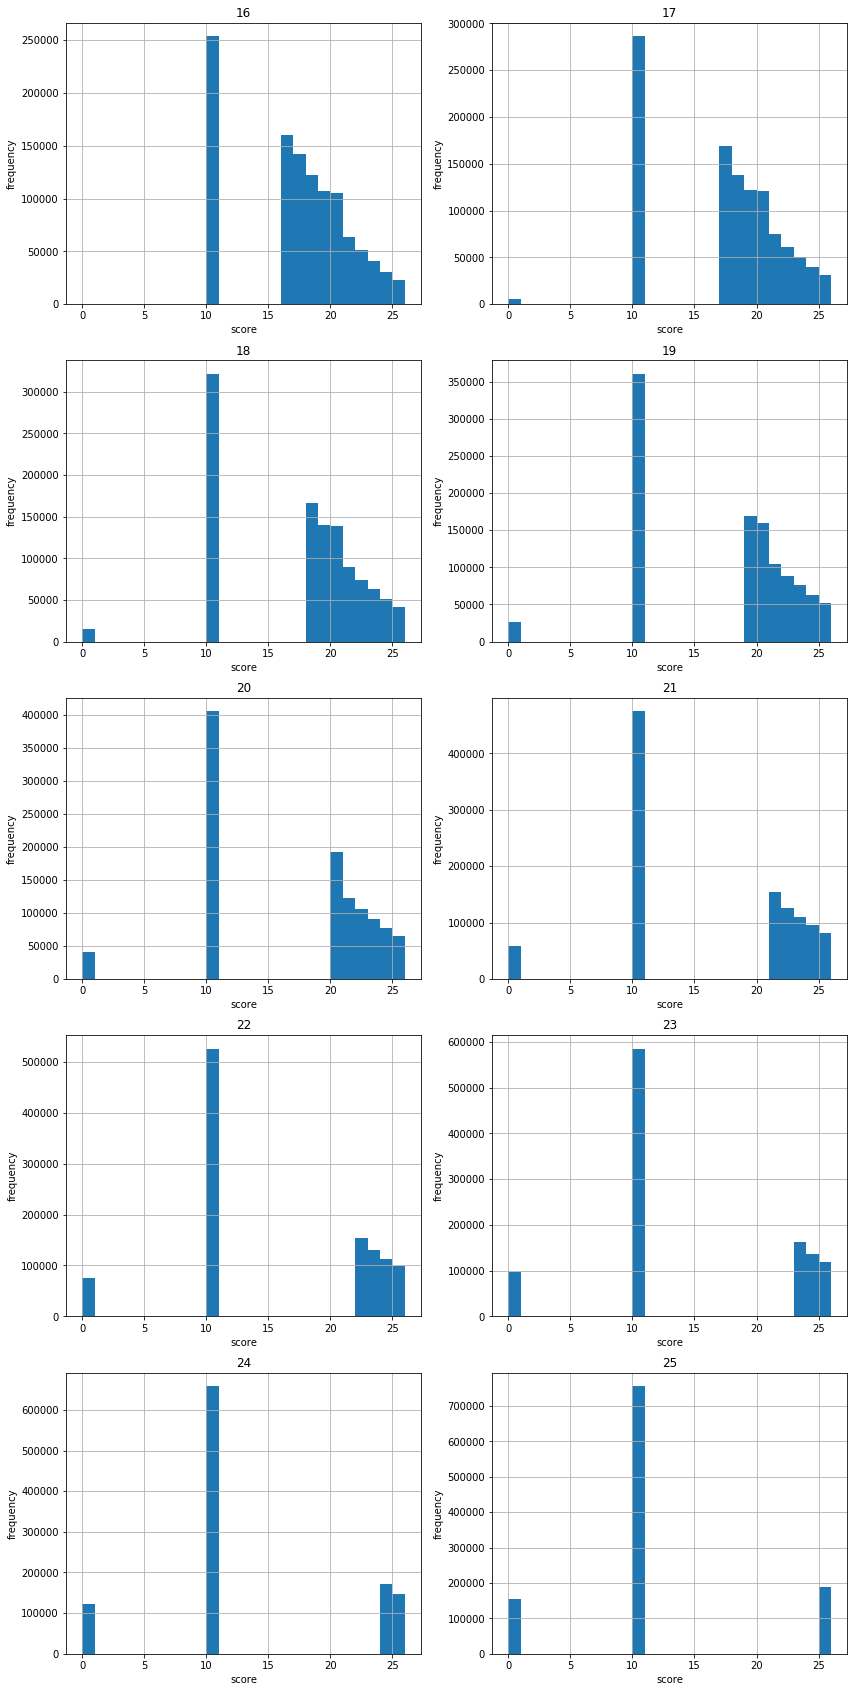

In [294]:
plt.figure(figsize = (14,30))        
for index, strat in enumerate(strategy_all_draw):
    plt.subplot(len(strategy_all_draw)/2, 2, index+1)
    strategy_distribution[strat], _, _ = plt.hist(strategy_all_draw[strat], bins = np.arange(0,27))
    plt.grid()
    plt.xlabel("score")
    plt.ylabel("frequency")
    plt.title(strat)

Text(0.5, 1.0, '10 Probability')

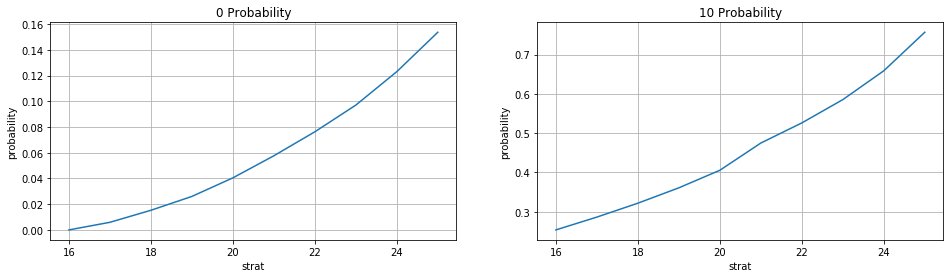

In [303]:
x_axis = np.arange(16,26)
probability_0 = list()
probability_10 = list()
for strat in strategy_distribution.values():
    probability_0.append(strat[0])
    probability_10.append(strat[10])
    
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(x_axis, list(map(lambda x: x/(iterations*10), probability_0)))
plt.grid()
plt.xlabel("strat")
plt.ylabel("probability")
plt.title("0 Probability")

plt.subplot(1,2,2)
plt.plot(x_axis, list(map(lambda x: x/(iterations*10), probability_10)))
plt.grid()
plt.xlabel("strat")
plt.ylabel("probability")
plt.title("10 Probability")

In [360]:
stratery_distribution_df = pd.DataFrame(strategy_distribution)/(10*iterations)
stratery_distribution_df.to_csv("empirical_strat_dist__df.csv")
stratery_distribution_df

,16,17,18,19,20,21,22,23,24,25
0,0.000000,0.005917,0.015259,0.026024,0.040462,0.057619,0.076270,0.097029,0.123035,0.153649
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [355]:
win_rate = dict()
for obj in strategy_comparison_dict.values():
    limit_1, limit_2 = obj.get_limits()
    current_results = obj.get_df()["Results"].value_counts()
    if limit_1 == limit_2:
        win_rate.setdefault(limit_1, [])
        win_rate[limit_1] = win_rate[limit_1] + [current_results.loc[1] + int(current_results.loc[3]/2)]
    else:
        win_rate.setdefault(limit_1, [])
        win_rate[limit_1] = win_rate[limit_1] + [current_results.loc[1] + int(current_results.loc[3]/2)]
        win_rate.setdefault(limit_2, [])
        win_rate[limit_2] = win_rate[limit_2] + [current_results.loc[2] + int(current_results.loc[3]/2)]

In [361]:
win_rate_df = pd.DataFrame(win_rate, index = np.arange(16,26)).transpose()
normalised_win_rate_df = (win_rate_df/iterations)
normalised_win_rate_df.to_csv("empirical_normalised_win_rate.csv")
normalised_win_rate_df

,16,17,18,19,20,21,22,23,24,25
16,0.49923,0.45909,0.43393,0.43251,0.44214,0.48180,0.51981,0.57517,0.64822,0.74860
17,0.54091,0.50153,0.46519,0.45001,0.45231,0.48246,0.52052,0.56703,0.63820,0.73689
18,0.56606,0.53481,0.49856,0.47357,0.46841,0.48679,0.51797,0.56082,0.62624,0.71717
19,0.56749,0.54999,0.52642,0.49847,0.48248,0.49437,0.51295,0.54947,0.61426,0.69999
20,0.55786,0.54768,0.53158,0.51751,0.50056,0.50029,0.50693,0.54166,0.59589,0.67838
21,0.51819,0.51754,0.51321,0.50562,0.49971,0.49735,0.50345,0.52455,0.57069,0.64684
22,0.48018,0.47948,0.48202,0.48705,0.49307,0.49654,0.50004,0.51024,0.54770,0.61909
23,0.42482,0.43297,0.43917,0.45052,0.45833,0.47544,0.48975,0.50011,0.52822,0.58636
24,0.35178,0.36179,0.37376,0.38574,0.40411,0.42931,0.45230,0.47178,0.49920,0.54878
25,0.25139,0.26311,0.28283,0.30001,0.32161,0.35315,0.38091,0.41364,0.45121,0.50040


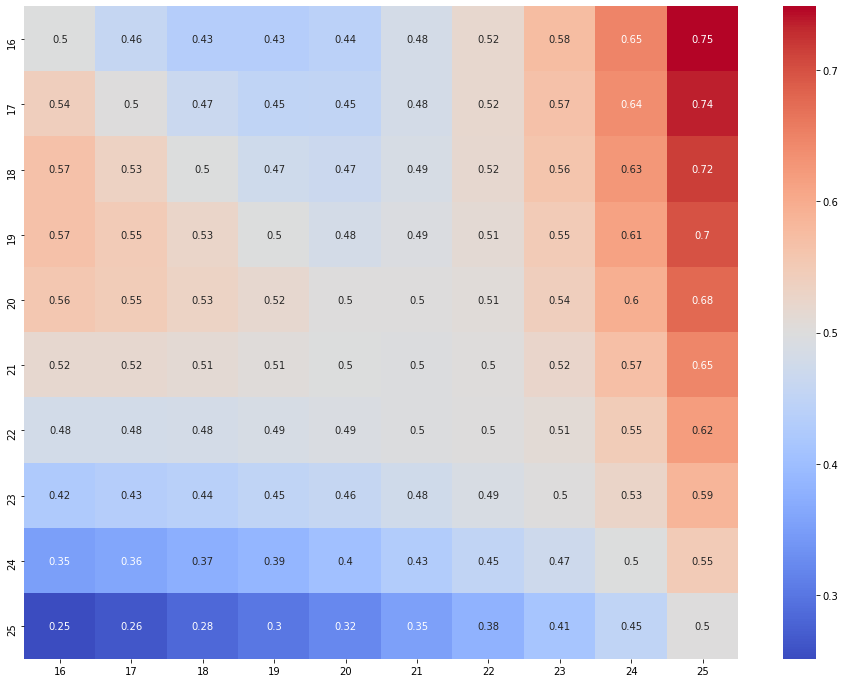

In [357]:
plt.figure(figsize = (16,12))
ax = sns.heatmap(win_rate_df/iterations, annot = True, cmap= "coolwarm")